In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
import fasttreeshap
import time
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle
import lightgbm as lgb

pd.set_option('display.max_columns', None)

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?


In [31]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest, average='binary'):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain, average = average),
                metricsObj.recall_score(yTrain, yPredTrain, average = average),
                metricsObj.f1_score(yTrain, yPredTrain, average = average),
                metricsObj.roc_auc_score(yTrain, yPredTrain, average = None if average == 'binary' else average)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest, average = average),
               metricsObj.recall_score(yTest, yPredTest, average = average),
               metricsObj.f1_score(yTest, yPredTest, average = average),
               metricsObj.roc_auc_score(yTest, yPredTest, average = None if average == 'binary' else average)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [32]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

- aggiungere cross validation
- passare a usare i sample
- guardare la dimesione dell'albero
- confrontare sample con dati interi

Here I change the type of some feature becuase since they come from a network package they are supposed to be a certain amount of bit maximum, I also checked before to do the change.

Then I will eclude the ip of the hosts, the port and the Unnamed: 0. Because the ip and ports are categorical but they are to many to fit in the model, and also there is not a good reason for train the model over the ip since it change based on the network so the attacker will always have a different one. About the Unnamed: 0 you can use that number to split this csv in mani csvs which is not a thing that we need to do so I removed that feature as well.

In [33]:
dtype_dict = {
    'Unnamed: 0': 'uint32',
    'uid': 'str',
    'originh': 'category',
    'originp': 'uint16',
    'responh': 'category',
    'responp': 'uint16',
    'flow_duration': 'float64',
    'fwd_pkts_tot': 'uint64',
    'bwd_pkts_tot': 'uint64',
    'fwd_data_pkts_tot': 'uint64',
    'bwd_data_pkts_tot': 'uint64',
    'fwd_pkts_per_sec': 'float64',
    'bwd_pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'down_up_ratio': 'float32',
    'fwd_header_size_tot': 'uint64',
    'fwd_header_size_min': 'uint8',
    'fwd_header_size_max': 'uint8',
    'bwd_header_size_tot': 'uint64',
    'bwd_header_size_min': 'uint8',
    'bwd_header_size_max': 'uint8',
    'flow_FIN_flag_count': 'uint64',
    'flow_SYN_flag_count': 'uint64',
    'flow_RST_flag_count': 'uint64',
    'fwd_PSH_flag_count': 'uint64',
    'bwd_PSH_flag_count': 'uint64',
    'flow_ACK_flag_count': 'uint64',
    'fwd_URG_flag_count': 'uint64',
    'bwd_URG_flag_count': 'uint64',
    'flow_CWR_flag_count': 'uint64',
    'flow_ECE_flag_count': 'uint64',
    'fwd_pkts_payload.min': 'uint16',
    'fwd_pkts_payload.max': 'uint16',
    'fwd_pkts_payload.tot': 'float64',
    'fwd_pkts_payload.avg': 'float64',
    'fwd_pkts_payload.std': 'float64',
    'bwd_pkts_payload.min': 'uint16',
    'bwd_pkts_payload.max': 'uint16',
    'bwd_pkts_payload.tot': 'float64',
    'bwd_pkts_payload.avg': 'float64',
    'bwd_pkts_payload.std': 'float64',
    'flow_pkts_payload.min': 'uint16',
    'flow_pkts_payload.max': 'uint16',
    'flow_pkts_payload.tot': 'float64',
    'flow_pkts_payload.avg': 'float64',
    'flow_pkts_payload.std': 'float64',
    'fwd_iat.min': 'float64',
    'fwd_iat.max': 'float64',
    'fwd_iat.tot': 'float64',
    'fwd_iat.avg': 'float64',
    'fwd_iat.std': 'float64',
    'bwd_iat.min': 'float64',
    'bwd_iat.max': 'float64',
    'bwd_iat.tot': 'float64',
    'bwd_iat.avg': 'float64',
    'bwd_iat.std': 'float64',
    'flow_iat.min': 'float64',
    'flow_iat.max': 'float64',
    'flow_iat.tot': 'float64',
    'flow_iat.avg': 'float64',
    'flow_iat.std': 'float64',
    'payload_bytes_per_second': 'float64',
    'fwd_subflow_pkts': 'float64',
    'bwd_subflow_pkts': 'float64',
    'fwd_subflow_bytes': 'float64',
    'bwd_subflow_bytes': 'float64',
    'fwd_bulk_bytes': 'float64',
    'bwd_bulk_bytes': 'float64',
    'fwd_bulk_packets': 'float32',
    'bwd_bulk_packets': 'float32',
    'fwd_bulk_rate': 'float64',
    'bwd_bulk_rate': 'float64',
    'active.min': 'float64',
    'active.max': 'float64',
    'active.tot': 'float64',
    'active.avg': 'float64',
    'active.std': 'float64',
    'idle.min': 'float64',
    'idle.max': 'float64',
    'idle.tot': 'float64',
    'idle.avg': 'float64',
    'idle.std': 'float64',
    'fwd_init_window_size': 'uint16',
    'bwd_init_window_size': 'uint16',
    'fwd_last_window_size': 'uint16',
    'traffic_category': 'category',
    'Label': 'bool'
}

selected_features = [
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size", "traffic_category", "Label"
]

In [34]:
ds = pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [35]:
with open('mlp_data/ds.pickle', 'wb') as handle:
    pickle.dump(ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555278 entries, 0 to 555277
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   flow_duration             555278 non-null  float64 
 1   fwd_pkts_tot              555278 non-null  uint64  
 2   bwd_pkts_tot              555278 non-null  uint64  
 3   fwd_data_pkts_tot         555278 non-null  uint64  
 4   bwd_data_pkts_tot         555278 non-null  uint64  
 5   fwd_pkts_per_sec          555278 non-null  float64 
 6   bwd_pkts_per_sec          555278 non-null  float64 
 7   flow_pkts_per_sec         555278 non-null  float64 
 8   down_up_ratio             555278 non-null  float32 
 9   fwd_header_size_tot       555278 non-null  uint64  
 10  fwd_header_size_min       555278 non-null  uint8   
 11  fwd_header_size_max       555278 non-null  uint8   
 12  bwd_header_size_tot       555278 non-null  uint64  
 13  bwd_header_size_min       555

In [37]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000
mean,9.306544,18.264091,18.892578,7.956928,15.803417,1720.704202,1674.140666,3394.844869,0.887003,6.361381e+02,19.901433,24.607501,5.754280e+02,16.545190,19.689366,0.562095,0.923988,0.503098,7.084219,10.782839,34.937831,0.001439,0.000011,0.002329,0.000038,22.699050,207.591415,1.872353e+03,52.682038,56.488003,31.246709,1252.857824,2.659391e+04,309.276711,363.239480,22.705447,1263.603752,2.846627e+04,186.045581,299.247061,8.932046e+05,5.102050e+06,9.134269e+06,1.190675e+06,9.329549e+05,1.528412e+04,4.232945e+06,7.234529e+06,3.454519e+05,9.634418e+05,8.937461e+05,5.202171e+06,9.312579e+06,1.080620e+06,7.082713e+05,3.516315e+04,12.653119,13.143448,1507.875699,1.592495e+04,18.984345,6.423852e+03,0.030403,2.513407,1.248447e+03,5.797473e+06,6.405506e+05,8.806241e+05,9.996375e+05,7.352865e+05,1.335883e+05,3.490637e+06,5.000630e+06,8.312942e+06,4.073219e+06,7.992576e+05,14750.725718,21005.879513,4546.872210
std,101.802730,463.901484,469.078877,73.441224,467.349374,4994.579973,4548.503983,9316.856663,0.511737,1.762560e+04,12.524893,16.577095,1.495092e+04,12.151789,15.924656,0.825811,1.018941,0.898075,73.276271,173.178129,932.467347,0.038844,0.003287,0.057376,0.006710,33.855436,287.060480,2.229359e+04,53.300571,89.671573,48.048751,2778.113834,4.004711e+05,569.643855,648.563051,33.867741,2774.930843,4.038744e+05,286.173780,524.095261,7.145073e+06,2.315940e+07,1.017571e+08,7.273388e+06,4.779988e+06,2.570718e+05,2.217501e+07,7.332596e+07,1.682992e+06,4.913081e+06,7.144566e+06,2.323061e+07,1.018055e+08,7.190908e+06,3.437376e+06,2.183837e+05,85.057715,89.297659,17077.706573,1.484343e+05,872.755605,

In [38]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

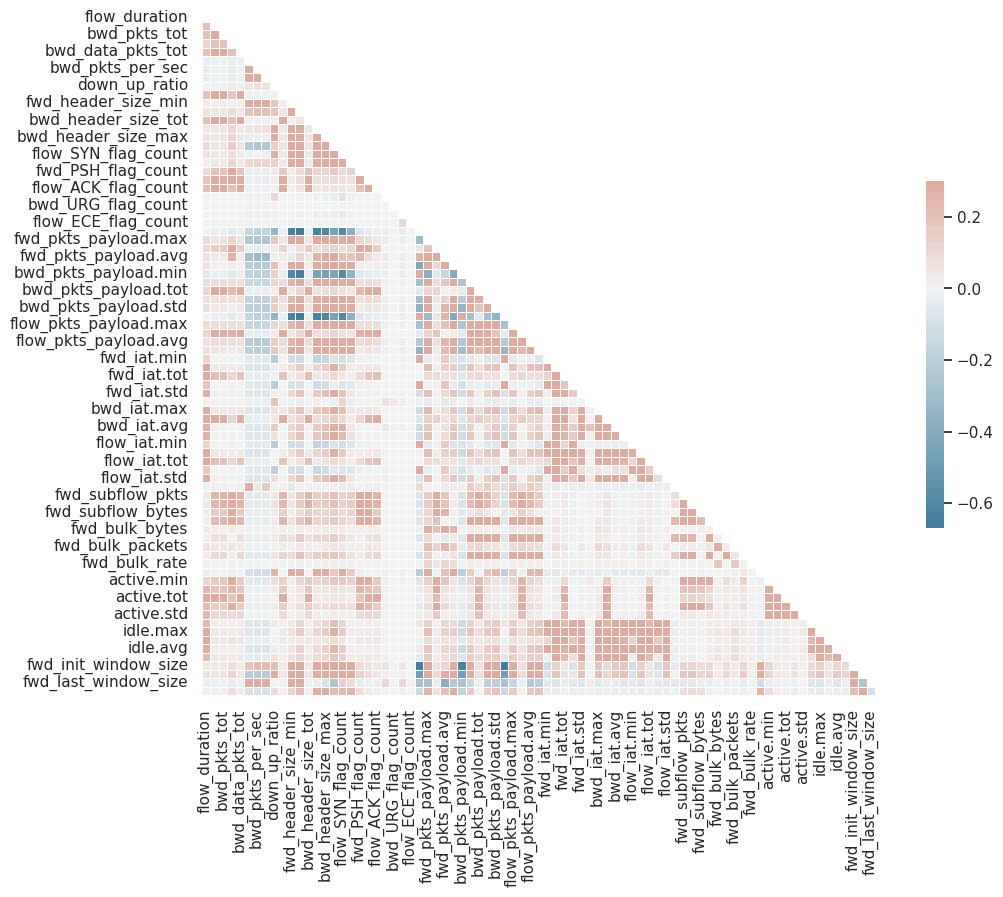

In [39]:
def show_corr_matrix():
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = ds.loc[:, ds.columns != 'traffic_category'].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
show_corr_matrix()

In [40]:
def compute_ratio(data):
    # Get ratio instead of raw numbers using normalize=True
    ratio = data['traffic_category'].value_counts(normalize=True)

    # Round and then convert to percentage
    ratio = ratio.round(4)*100

    # convert to a DataFrame and store in variable 'traffic_category_ratios'
    # We'll use this variable to compare ratios for samples 
    # selected using SRS and Stratified Sampling 
    traffic_category_ratios = pd.DataFrame({'Ratio':ratio})
    print(traffic_category_ratios)
    
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               62.57
Background           30.64
Probing               4.21
Bruteforce            1.06
Bruteforce-XML        0.93
XMRIGCC CryptoMiner   0.59


In [41]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [42]:
category_size = 3279
sampling_weights = {'Background': category_size * 2, 'Benign': category_size * 2, 'XMRIGCC CryptoMiner': category_size, 'Probing': category_size, 'Bruteforce': category_size, 'Bruteforce-XML': category_size}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

ricordarsi di fare fit una volta sola per tutti i dati e poi usare transform dove serve

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

This random forest with max depth 6 is better then any other max depth, and by descreasing the number of estimator to two we can see that the f1 is still 0,96 

In [44]:
def stratified_under_sample(group: pd.DataFrame, k: int, random_state: int):
    global category_size
    # shuffle data
    group = group.sample(frac=1, random_state=random_state)
    
    # making a dictionary for checking if all the groups are equally insert into the array
    unique_categories = set(group)
    
    # getting the size of each category per fold
    folded_category = category_size // k
    
    # storing temporary data
    test_res = []
    train_res = []

    for i in range(k):
        test_indexes = []
        train_indexes = []
        
        # for each iteration of the outer loop we need to reset dict
        count_type = {category: 0 for category in unique_categories}
        
        for category in unique_categories:
            # making a window of data to retreive
            if (category == 'Background') | (category == 'Benign'):
                start = (folded_category * 2) * i
                stop = (folded_category * 2) * (i + 1)
            else:
                start = folded_category * i
                stop = folded_category * (i + 1)
            test_indexes.extend(group[group == category].iloc[start:stop].index)
        
        for x in group.index:
            if x not in test_indexes:
                train_indexes.append(x)
                
        # shuffling the data with the same seed in order to have the same result in both the dataset
        np.random.shuffle(test_indexes)
        test_res.append(test_indexes)
        np.random.shuffle(train_indexes)
        train_res.append(train_indexes)
        
    return test_res, train_res

In [247]:
def cross_validation(X, y, group, verbose):
    test_kfold, train_kfold = stratified_under_sample(group, 10, 12)
    
    cvscores = []

    start_cv = time.time()
    for test, train in zip(test_kfold, train_kfold):
        train_data = lgb.Dataset(X.loc[train], label=y.loc[train])
        
        bst = lgb.train(param, train_data)
        
        y_predicted = bst.predict(X.loc[test]) >= 0.5

        cvscores.append(metrics.f1_score(y.loc[test], y_predicted))
    end_cv = time.time()    
    
    return np.mean(cvscores), np.std(cvscores), end_cv - start_cv
        
%time cross_validation(ds[x_features], ds.Label, y_res, True)

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


CPU times: user 10.2 s, sys: 87.8 ms, total: 10.3 s
Wall time: 6.33 s


(0.9410892857475963, 0.0038681187575691513, 1.5617008209228516)

In [45]:
train_data = lgb.Dataset(X_train, label=y_train)

In [246]:
param = {
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'objective': 'binary',  # Binary classification
    'metric': 'f1',  # F1 score as the evaluation metric
    'num_leaves': 16,  # Maximum number of leaves in one tree
    'verbose': 0,  # Verbosity
    'num_iterations': 24,  # Number of trees to train
    'max_depth': 6,  # Maximum depth of trees
}

In [158]:
%%time
bst = lgb.train(param, train_data)

CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 113 ms


Found `num_iterations` in params. Will use it instead of argument


In [159]:
%time y_predicted_train = bst.predict(X_train) >= 0.5

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 16.8 ms


In [160]:
%time y_predicted_test = bst.predict(X_test) >= 0.5

CPU times: user 7.56 ms, sys: 0 ns, total: 7.56 ms
Wall time: 5.84 ms


In [161]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.939242,0.935392
1,PRECISION,0.892915,0.886371
2,RECALL,0.998189,0.998857
3,F1 SCORE,0.942622,0.939258
4,AUC,0.939245,0.935380


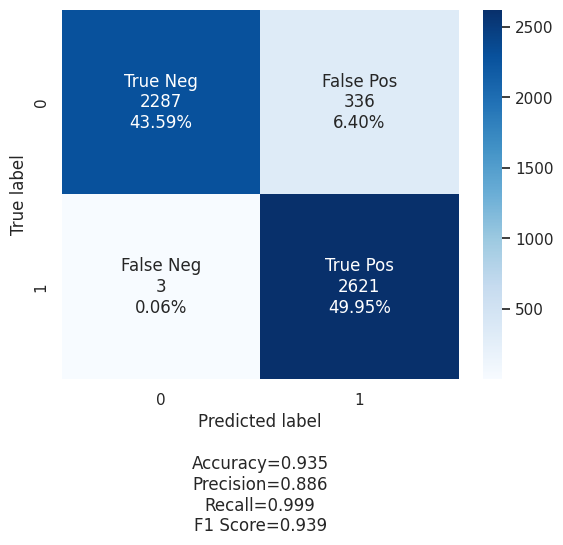

In [162]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [165]:
# Create a plot for each tree in the model
for i in range(bst.num_trees()):
    graph = lgb.create_tree_digraph(bst, tree_index=i, name='Tree {}'.format(i), show_info=['split_gain', 'internal_value', 'leaf_count'])
    graph.render(filename='tree_{}'.format(i), directory='lgb/tree', format='pdf')

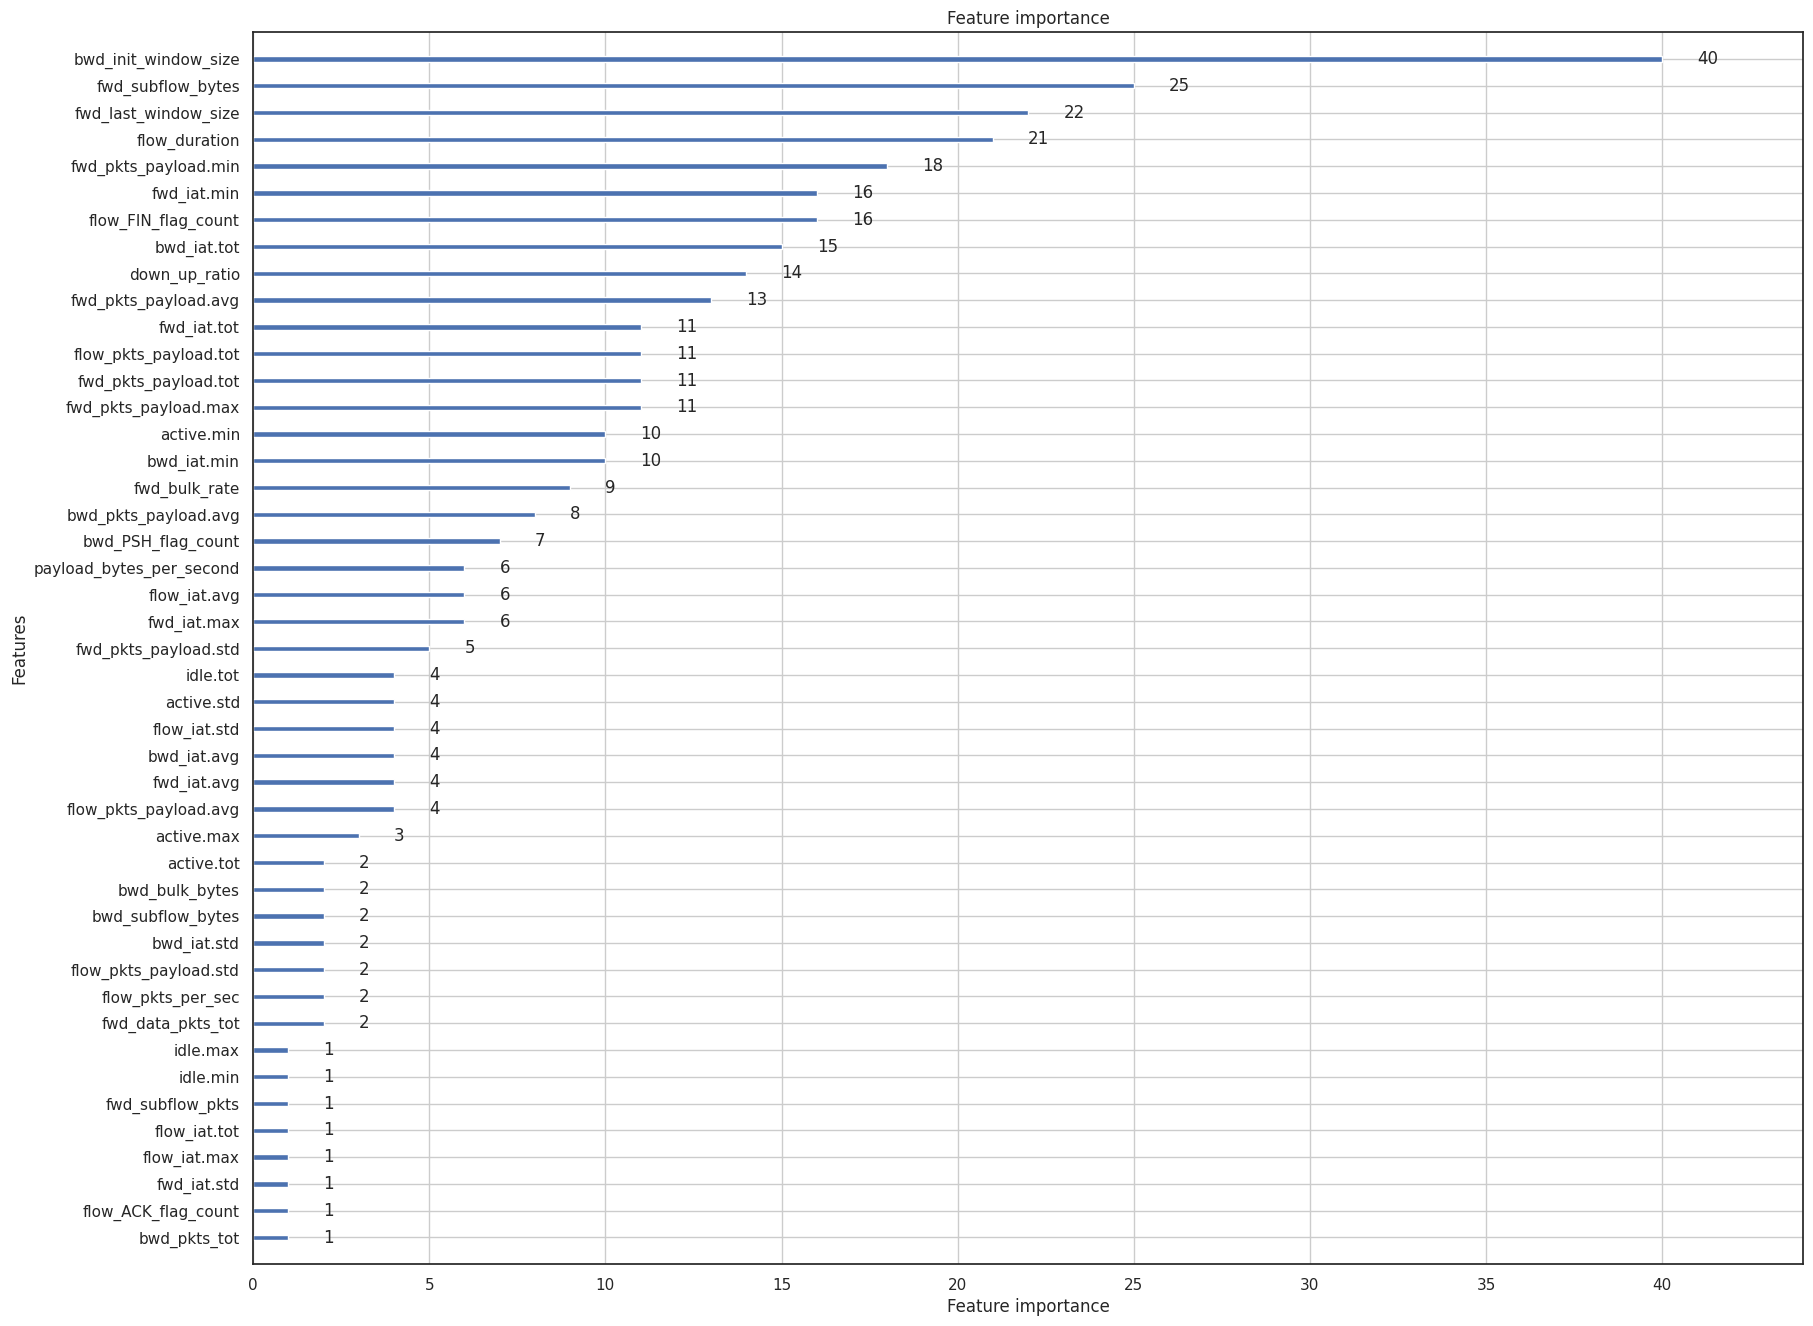

In [177]:
lgb.plot_importance(bst, figsize=(20, 16))

plt.show()

In [194]:
%%time

explainer = fasttreeshap.TreeExplainer(bst)
sv = explainer.shap_values(ds[x_features])

exp = Explanation(sv, 
                  np.mean(bst.predict(ds[x_features]) >= 0.5), 
                  data=ds[x_features].values, 
                  feature_names=x_features)

CPU times: user 24.7 s, sys: 2.26 s, total: 27 s
Wall time: 4.84 s


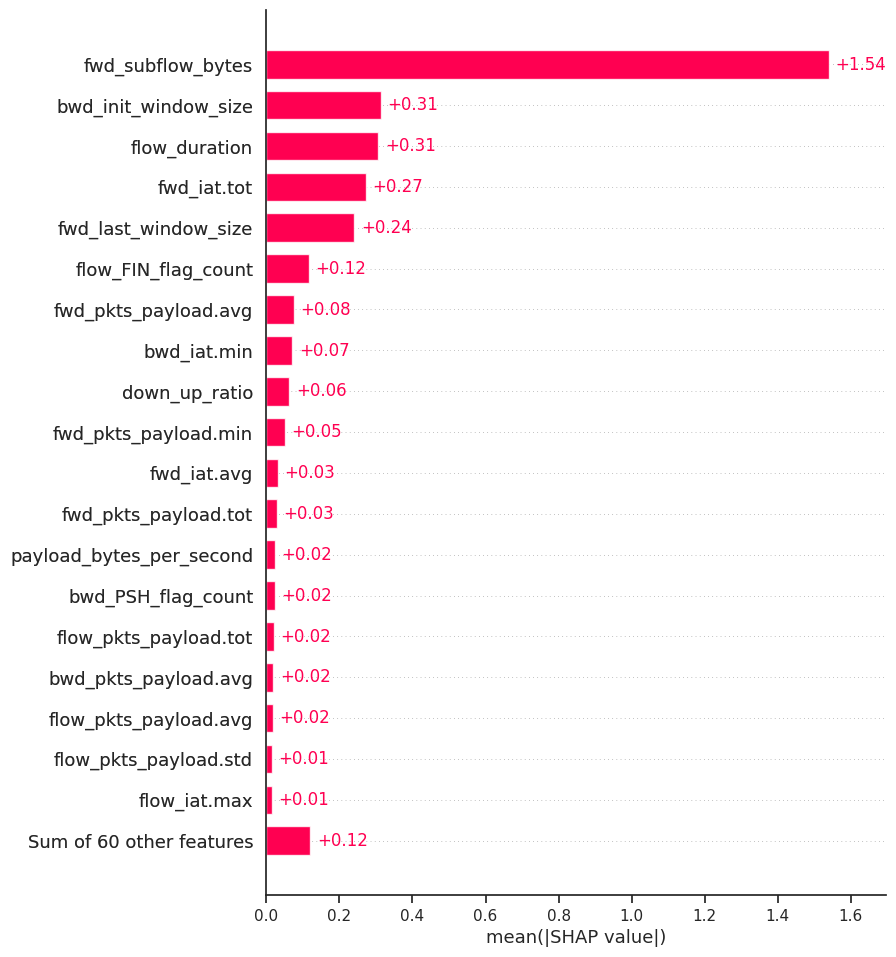

In [195]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

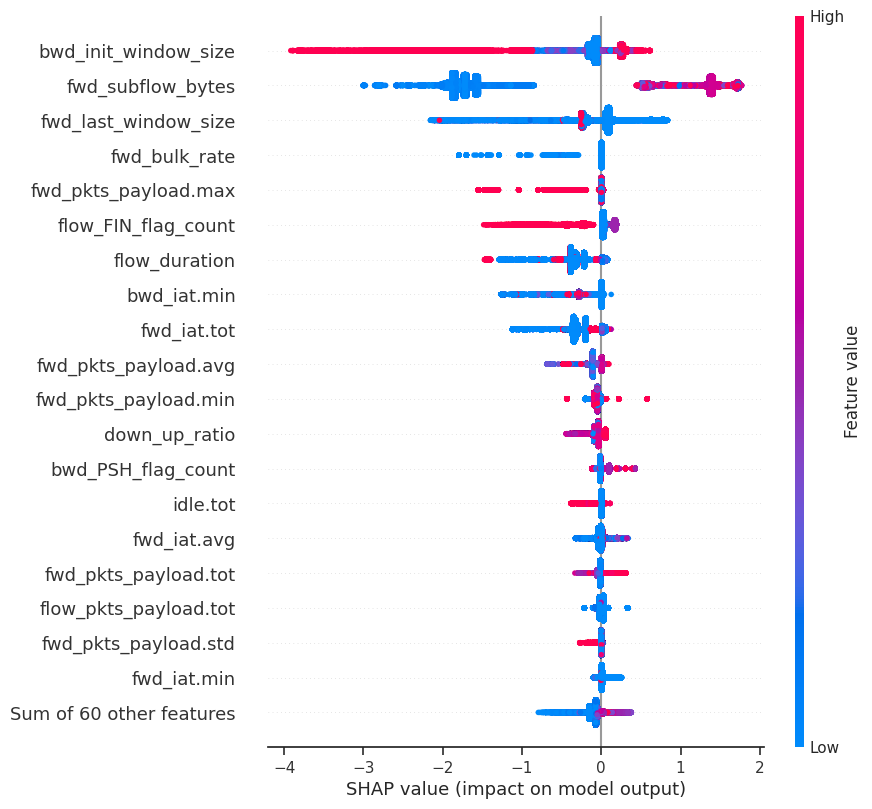

In [196]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [197]:
feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,1.539411,fwd_subflow_bytes
77,0.312972,bwd_init_window_size
0,0.306685,flow_duration
42,0.271502,fwd_iat.tot
78,0.241229,fwd_last_window_size
15,0.116855,flow_FIN_flag_count
28,0.075889,fwd_pkts_payload.avg
45,0.071415,bwd_iat.min
8,0.062981,down_up_ratio
25,0.050989,fwd_pkts_payload.min


In [198]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [209]:
%%time

def get_score(features):
    X = X_res[features]
    y = ds.loc[y_res.index].Label
    cv_mean, cv_std, cv_time = cross_validation(X, y, y_res, 0)
    return cv_mean, cv_std, len(features), cv_time

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    cv_time = []

    # making a warm up run otherwise the first one will be always slower than the others
    # only one features so that it can be as fast as possibile
    get_score(['fwd_iat.tot'])

    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])    
    cv_time.append(result[3])
    
    for i in range(1,len(feature_above_zero)):
        print(f"testing with {len(feature_above_zero[:-i])} features")
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        cv_time.append(result[3])
        
    return scores, score_std, n_features, cv_time

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num

testing with 44 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 43 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 42 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 41 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 40 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 39 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 38 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 37 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 36 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 35 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 34 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 33 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 32 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 31 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 30 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 29 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 28 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 27 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 26 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 25 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 24 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 23 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 22 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 21 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 20 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 19 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 18 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 17 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 16 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 15 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 14 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 13 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 12 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 11 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 10 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 9 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 8 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 7 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 6 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 5 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 4 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 3 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


testing with 2 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 5min 3s, 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


<Axes: xlabel='n_features', ylabel='cv_time'>

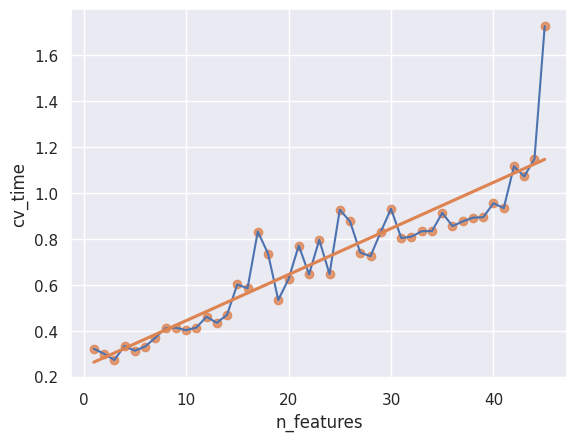

In [210]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

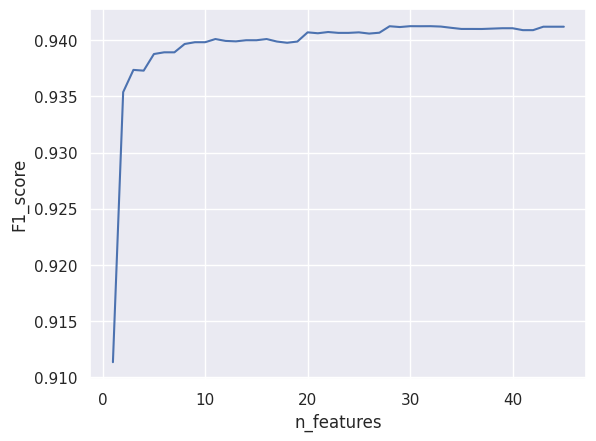

In [211]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

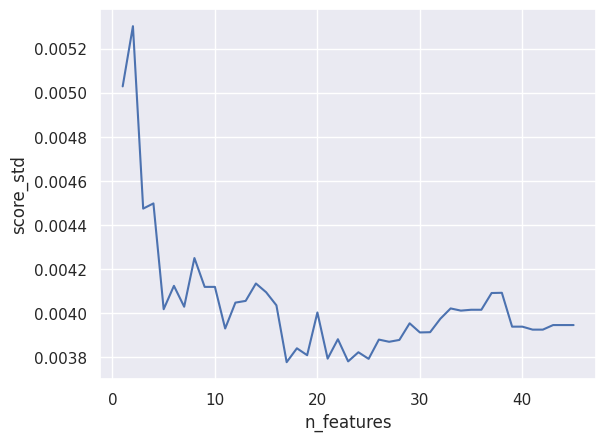

In [212]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [213]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
13,0.941243,0.003974,32,0.810490
15,0.941243,0.003912,30,0.931836
14,0.941239,0.003913,31,0.804462
17,0.941239,0.003877,28,0.725449
12,0.941210,0.004021,33,0.834092
0,0.941197,0.003945,45,1.726710
1,0.941197,0.003945,44,1.148828
2,0.941197,0.003945,43,1.072372
16,0.941167,0.003953,29,0.830924
11,0.941100,0.004011,34,0.834711


In [234]:
# add also training time
attack_f1 = []
attack_recall = []
attack_precision = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

# warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
warmup = True


def test_zero_day(attack, features, rus, rus_attack):
    print(f"training with {len(features)} features")
    global warmup
    
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
    y_attack = ds.loc[y_attack.index].Label
    
    cv_mean, cv_std, cv_time = cross_validation(X_res, ds.loc[y_res.index].Label, y_res, 0)
    X_res = lgb.Dataset(X_res, label=ds.loc[y_res.index].Label)
    
    if warmup:
        bst = lgb.train(param, X_res)
        bst.predict(X_attack)
    
    start_fit = time.time()
    bst = lgb.train(param, X_res)
    end_fit = time.time()
    
    start_pred = time.time()
    y_predicted = bst.predict(X_attack)
    end_pred = time.time()
    y_predicted = y_predicted >= 0.5
    
    attack_f1.append(metrics.f1_score(y_attack, y_predicted))
    attack_recall.append(metrics.recall_score(y_attack, y_predicted))
    attack_precision.append(metrics.precision_score(y_attack, y_predicted))
    cv_score_avg.append(cv_mean)
    cv_score_std.append(cv_std)
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

    # at the very first iteration we change it to false
    warmup = False
    
def recursive_reduction(attack):
    global scaler
    # making a sample for having a 1:1 ration for positive and negative class
    # keep in mind that in the training I will have only three attacks, while for the test only one attack
    sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}
    
    # removing all the attack observations
    sampling_weights[attack] = 0
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    
    # adding the attack to the test dataset with the non attack traffic
    sampling_attack[attack] = 3279
    
    # making the dataset with only one attack
    rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)
    
    test_zero_day(attack, feature_above_zero, rus, rus_attack)

    for i in range(1,len(feature_above_zero)):
        test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)

for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
training with 45 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 44 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 43 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 42 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 41 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 40 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 39 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 38 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 37 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 36 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 35 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 34 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 33 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 32 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 31 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 30 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 29 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 28 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 27 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 26 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 25 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 24 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 23 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 22 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 21 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 20 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 19 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 18 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 17 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 16 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 15 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 14 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 13 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 12 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 11 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 10 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 9 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 8 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 7 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 6 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 5 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 4 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 3 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 2 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 1 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


CPU times: user 5min 15s, sys: 892 ms, total: 5min 16s
Wall time: 4min 21s
traing for  Probing
training with 45 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 44 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 43 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 42 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 41 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 40 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 39 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 38 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 37 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 36 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 35 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 34 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 33 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 32 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 31 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 30 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 29 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 28 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 27 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 26 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 25 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 24 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 23 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 22 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 21 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 20 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 19 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 18 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 17 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 16 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 15 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 14 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 13 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 12 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 11 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 10 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 9 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 8 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 7 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 6 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 5 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 4 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 3 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 2 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


CPU times: user 5min 21s, sys: 1.02 s, total: 5min 22s
Wall time: 4min 27s
traing for  Bruteforce
training with 45 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 44 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 43 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 42 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 41 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 40 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 39 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 38 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 37 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 36 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 35 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 34 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 33 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 32 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 31 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


training with 30 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 29 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 28 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


training with 27 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 26 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 25 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


training with 24 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 23 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 22 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 21 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 20 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 19 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 18 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 17 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 16 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 15 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 14 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 13 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 12 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 11 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 10 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 9 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 7 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training with 6 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument


training with 4 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


CPU times: user 5min 18s, sys: 967 ms, total: 5min 19s
Wall time: 4min 24s
traing for  Bruteforce-XML
training with 45 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 44 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 43 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 42 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 41 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 40 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 39 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 38 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 37 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 36 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 35 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 34 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 33 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 32 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 31 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 30 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 29 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 28 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 27 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 26 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 25 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 24 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 23 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 22 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 21 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 20 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 19 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 18 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 17 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 16 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 15 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 14 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 13 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 12 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 11 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 10 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 9 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 8 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 7 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 6 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 5 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 4 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 3 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


training with 2 features


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


In [235]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [236]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
178,0.931666,1.000000,0.872074,0.933770,0.035090,2,Bruteforce-XML,0.006553,0.000683,1
129,0.873445,0.877707,0.869224,0.939189,0.031873,6,Bruteforce,0.011034,0.001252,1
130,0.872760,0.876487,0.869066,0.939716,0.031625,5,Bruteforce,0.014093,0.001479,1
172,0.685623,0.588289,0.821550,0.939017,0.030618,8,Bruteforce-XML,0.017664,0.001263,1
177,0.664397,0.565416,0.805387,0.933849,0.032240,3,Bruteforce-XML,0.009095,0.000815,1
...,...,...,...,...,...,...,...,...,...,...
37,0.000545,0.000305,0.002538,0.944405,0.028293,8,XMRIGCC CryptoMiner,0.013972,0.000841,1
36,0.000545,0.000305,0.002558,0.944341,0.028319,9,XMRIGCC CryptoMiner,0.014671,0.001165,1
35,0.000545,0.000305,0.002558,0.944341,0.028319,10,XMRIGCC CryptoMiner,0.015872,0.001272,1
34,0.000545,0.000305,0.002545,0.944385,0.028298,11,XMRIGCC CryptoMiner,0.013576,0.000945,1


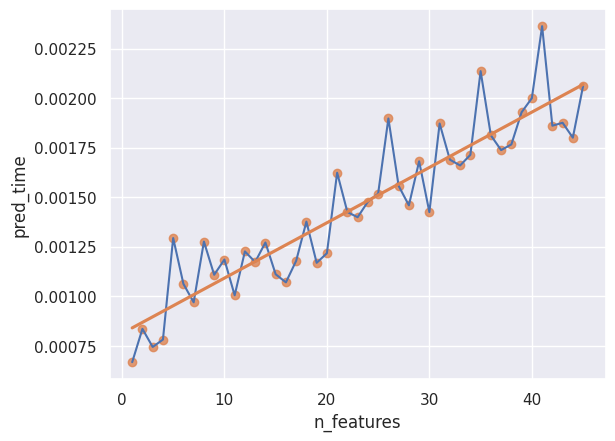

In [237]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

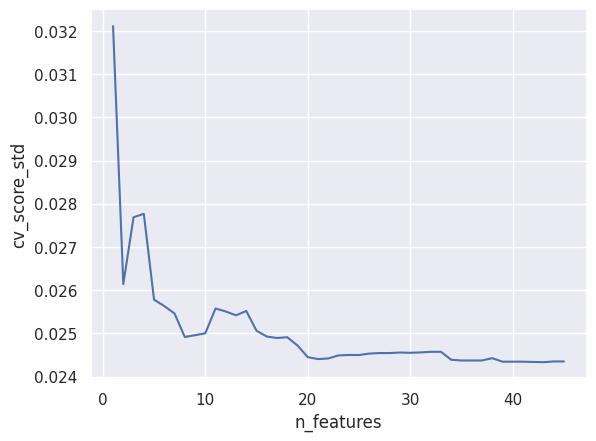

In [238]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [239]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
6,0.385074,0.360476,0.421485,0.950420,0.025633,0.010302,0.001063,0.75
5,0.384963,0.360400,0.421146,0.950237,0.025780,0.013948,0.001294,0.75
8,0.332726,0.281641,0.407116,0.950146,0.024917,0.016209,0.001276,0.75
7,0.329034,0.276914,0.405787,0.950597,0.025460,0.013081,0.000970,0.75
12,0.323463,0.269366,0.405153,0.951346,0.025507,0.016780,0.001227,0.75
13,0.323276,0.269137,0.405088,0.951330,0.025418,0.017196,0.001173,0.75
11,0.323247,0.269137,0.404986,0.951359,0.025577,0.015131,0.001006,0.75
14,0.312700,0.256557,0.400508,0.951213,0.025519,0.018572,0.001272,0.50
2,0.240277,0.253965,0.277909,0.947616,0.026142,0.007193,0.000836,0.75


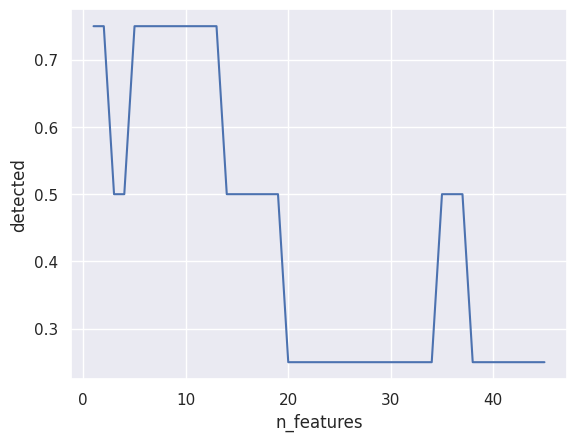

In [240]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

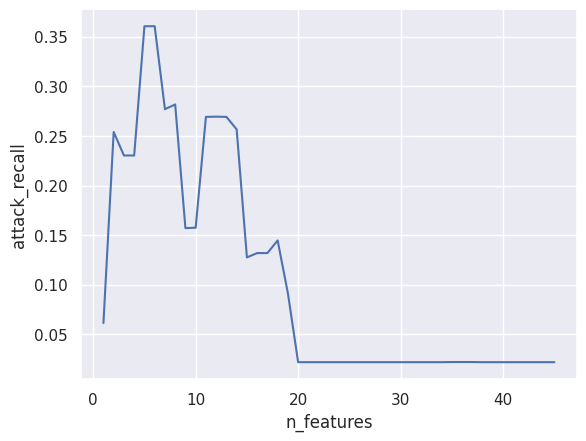

In [241]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [242]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
6,0.385074,0.360476,0.421485,0.950420,0.025633,0.010302,0.001063
5,0.384963,0.360400,0.421146,0.950237,0.025780,0.013948,0.001294
8,0.332726,0.281641,0.407116,0.950146,0.024917,0.016209,0.001276
7,0.329034,0.276914,0.405787,0.950597,0.025460,0.013081,0.000970
12,0.323463,0.269366,0.405153,0.951346,0.025507,0.016780,0.001227
13,0.323276,0.269137,0.405088,0.951330,0.025418,0.017196,0.001173
11,0.323247,0.269137,0.404986,0.951359,0.025577,0.015131,0.001006
14,0.312700,0.256557,0.400508,0.951213,0.025519,0.018572,0.001272
3,0.285444,0.230253,0.382854,0.946106,0.027689,0.008006,0.000745


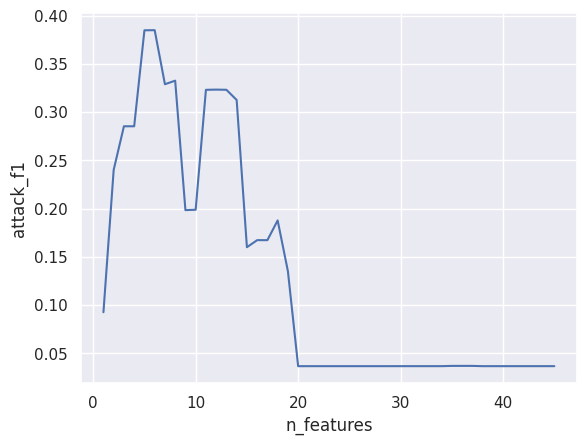

In [243]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [244]:
zero_day_feature_reduction_scores.query('n_features == 5')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
40,0.000544,0.000305,0.002525,0.944144,0.028679,5,XMRIGCC CryptoMiner,0.011642,0.001464,1
85,0.000000,0.000000,0.000000,0.979331,0.010786,5,Probing,0.020312,0.001421,0
130,0.872760,0.876487,0.869066,0.939716,0.031625,5,Bruteforce,0.014093,0.001479,1
175,0.666547,0.564806,0.812994,0.937755,0.032032,5,Bruteforce-XML,0.009743,0.000812,1
